# Implementation of AlexNet

In [1]:
import os
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from PIL import Image
from keras.datasets import mnist
from keras.models import Sequential
from keras import regularizers
from keras.datasets import cifar10
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization 
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import h5py
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_annotations_map():
	valAnnotationsPath = 'tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt'
	valAnnotationsFile = open(valAnnotationsPath, 'r')
	valAnnotationsContents = valAnnotationsFile.read()
	valAnnotations = {}

	for line in valAnnotationsContents.splitlines():
		pieces = line.strip().split()
		valAnnotations[pieces[0]] = pieces[1]

	return valAnnotations

In [3]:
def load_images(path,num_classes):
    #Load images
    
    print('Loading ' + str(num_classes) + ' classes')

    X_train=np.zeros([num_classes*500,3,32,32],dtype='uint8')
    y_train=np.zeros([num_classes*500], dtype='uint8')

    trainPath=path+'/train'

    print('loading training images...');

    i=0
    j=0
    annotations={}
    for sChild in os.listdir(trainPath):
        sChildPath = os.path.join(os.path.join(trainPath,sChild),'images')
        annotations[sChild]=j
        for c in os.listdir(sChildPath):
            X=np.array(Image.open(os.path.join(sChildPath,c)))
            if len(np.shape(X))==2:
                X_train[i]=np.array([X,X,X])
            else:
                X_train[i]=np.transpose(X,(2,0,1))
            y_train[i]=j
            i+=1
        j+=1
        if (j >= num_classes):
            break

    print('finished loading training images')

    val_annotations_map = get_annotations_map()

    X_test = np.zeros([num_classes*50,3,32,32],dtype='uint8')
    y_test = np.zeros([num_classes*50], dtype='uint8')


    print('loading test images...')

    i = 0
    testPath=path+'/val/images'
    for sChild in os.listdir(testPath):
        if val_annotations_map[sChild] in annotations.keys():
            sChildPath = os.path.join(testPath, sChild)
            X=np.array(Image.open(sChildPath))
            if len(np.shape(X))==2:
                X_test[i]=np.array([X,X,X])
            else:
                X_test[i]=np.transpose(X,(2,0,1))
            y_test[i]=annotations[val_annotations_map[sChild]]
            i+=1
        else:
            pass



    return X_train,y_train,X_test,y_test

In [6]:
from google.colab import files
uploaded=files.upload()

Saving tiny-imagenet-200.zip to tiny-imagenet-200 (2).zip


In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['tiny-imagenet-200.zip']), 'r')
data.extractall()

In [4]:
train_data_dir = 'tiny-imagenet-200/tiny-imagenet-200/train'  
validation_data_dir = 'tiny-imagenet-200/tiny-imagenet-200/val'  
test_data_dir = 'tiny-imagenet-200/tiny-imagenet-200/test' 
target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),
     ' %', '\n - # of epochs: ', 2, '\n - batch size: ', 500)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n028148

In [5]:
path='tiny-imagenet-200/tiny-imagenet-200'
X_train,y_train,X_test,y_test=load_images(path,nb_classes)

Loading 200 classes
loading training images...
finished loading training images
loading test images...


In [8]:
X_train.shape

(100000, 3, 32, 32)

In [20]:
X_test.shape

(10000, 3, 32, 32)

In [6]:
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.to_categorical(y_test, nb_classes)

In [7]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(3,32,32), kernel_size=(11,11), strides=(2,2), padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=1024, kernel_size=(2,2), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(800, input_shape=(32*32*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(800))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(256))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(nb_classes))
       
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 16, 96)         371808    
_________________________________________________________________
activation_1 (Activation)    (None, 2, 16, 96)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 8, 96)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 8, 256)         614656    
_________________________________________________________________
activation_2 (Activation)    (None, 1, 8, 256)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 4, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 4, 512)         1180160   
__________

In [9]:
lr=0.001
opt = keras.optimizers.Adam(lr=lr, decay=1e-6) #momentum=0.9, nesterov=True)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [11]:
history=model.fit(X_train, y_train,
              batch_size=300,
              epochs=20,
              validation_data=(X_test, y_test),
              shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 1004s 10ms/step - loss: 5.2999 - acc: 0.0049 - val_loss: 5.2981 - val_acc: 0.0052
Epoch 2/20
100000/100000 [==============================] - 1027s 10ms/step - loss: 5.2995 - acc: 0.0053 - val_loss: 5.2984 - val_acc: 0.0050
Epoch 3/20
100000/100000 [==============================] - 1048s 10ms/step - loss: 5.2916 - acc: 0.0059 - val_loss: 5.2461 - val_acc: 0.0104
Epoch 4/20
100000/100000 [==============================] - 679s 7ms/step - loss: 5.1433 - acc: 0.0121 - val_loss: 5.0491 - val_acc: 0.0196
Epoch 5/20
100000/100000 [==============================] - 680s 7ms/step - loss: 5.0199 - acc: 0.0205 - val_loss: 4.9425 - val_acc: 0.0259
Epoch 6/20
100000/100000 [==============================] - 859s 9ms/step - loss: 4.9504 - acc: 0.0259 - val_loss: 4.9196 - val_acc: 0.0302
Epoch 7/20
100000/100000 [=============================

In [12]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 15s 2ms/step
Test loss: 4.3940801948547366
Test accuracy: 0.0921


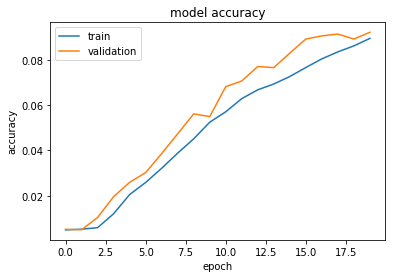

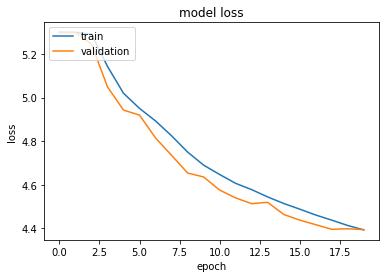

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()